In [2]:

from coregenes.preprocessing.mappers import GWASMapper, AdjacencyMapper
from coregenes.preprocessing.preprocessor import PreProcessor
from coregenes.utils.config import Config

import matplotlib.pyplot as plt
import os
import numpy as np

In [1]:
import os
os.chdir("..")

In [3]:
config = Config()
gwasmapper = GWASMapper(config.input.gene_sets, config.input.gwas, "coregenes/mapping.json")
adjacencymapper = AdjacencyMapper(mapping_file="coregenes/adjacencies.json")

gwasmappings = gwasmapper.get_mappings("Immune_Dysregulation", fields="ground_truth")
#adjacencies = adjacencymapper.get_mappings("GRNDB-adipose_tissue")
adjacencies = adjacencymapper.get_mappings("GRNDB-pituitary")
#adjacencies = adjacencymapper.get_mappings("BioPlex 3.0 293T")
config.input.log_expression = True

preprocessor = PreProcessor(config, gwasmappings, adjacencies)
X, y, adj = preprocessor.get_data()
feature_names = preprocessor.get_feature_names()


In [12]:
len(feature_names)

93

In [5]:
repeat_times = X.shape[0]

X_flat = X.flatten()
print(X[:2,:2])
print(X_flat[:2])

[[-0.36708861 -0.05762961]
 [ 0.35443038 -0.63553879]]
[-0.36708861 -0.05762961]


In [8]:
is_positive = [i in preprocessor.pos_idx for i in range(X.shape[0])]

In [11]:
sum(is_positive)

525

In [6]:
import pandas as pd
x_df = pd.DataFrame(X_flat, columns=["values"])
x_df["feature"] = preprocessor.get_feature_names() * repeat_times

In [12]:
x_df["is_positive"] = np.repeat(is_positive, X.shape[1])

In [1]:
import pandas as pd

df = pd.read_csv("/home/icb/florin.ratajczak/ppi-core-genes/data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", skiprows=2, sep="\t", index_col=0)
df.drop("Description",axis=1, inplace=True)

In [2]:
df["Whole Blood"].describe()

count     56202.000000
mean         15.233666
std        1113.018285
min           0.000000
25%           0.000000
50%           0.000000
75%           0.492100
max      246600.000000
Name: Whole Blood, dtype: float64

<AxesSubplot:>

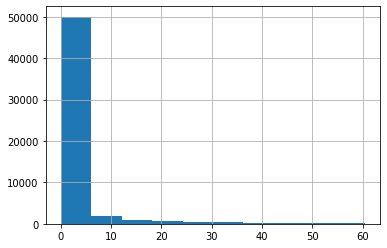

In [32]:
removed_max = df["Whole Blood"][df["Whole Blood"] < df["Whole Blood"].quantile(0.99)]
df["Whole Blood"][df["Whole Blood"] < (df["Whole Blood"].mean() + (4 * removed_max.std()))].hist()

In [38]:
df.melt()

,variable,value
0,Adipose - Subcutaneous,0.056945
1,Adipose - Subcutaneous,11.850000
2,Adipose - Subcutaneous,0.061460
3,Adipose - Subcutaneous,0.038600
4,Adipose - Subcutaneous,0.035695
...,...,...
2978701,Whole Blood,1085.000000
2978702,Whole Blood,3.568000
2978703,Whole Blood,2384.000000
2978704,Whole Blood,0.000000


In [5]:
def clip_df(input_df, clip_top_quantile=0.01):
    df = input_df.copy(deep=True)
    for column in df.columns:
        removed_max = df[column][df[column] < df[column].quantile(1 - clip_top_quantile)]
        df[column][df[column] > (df[column].mean() + (3 * removed_max.std()))] = removed_max.max()

    return df

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


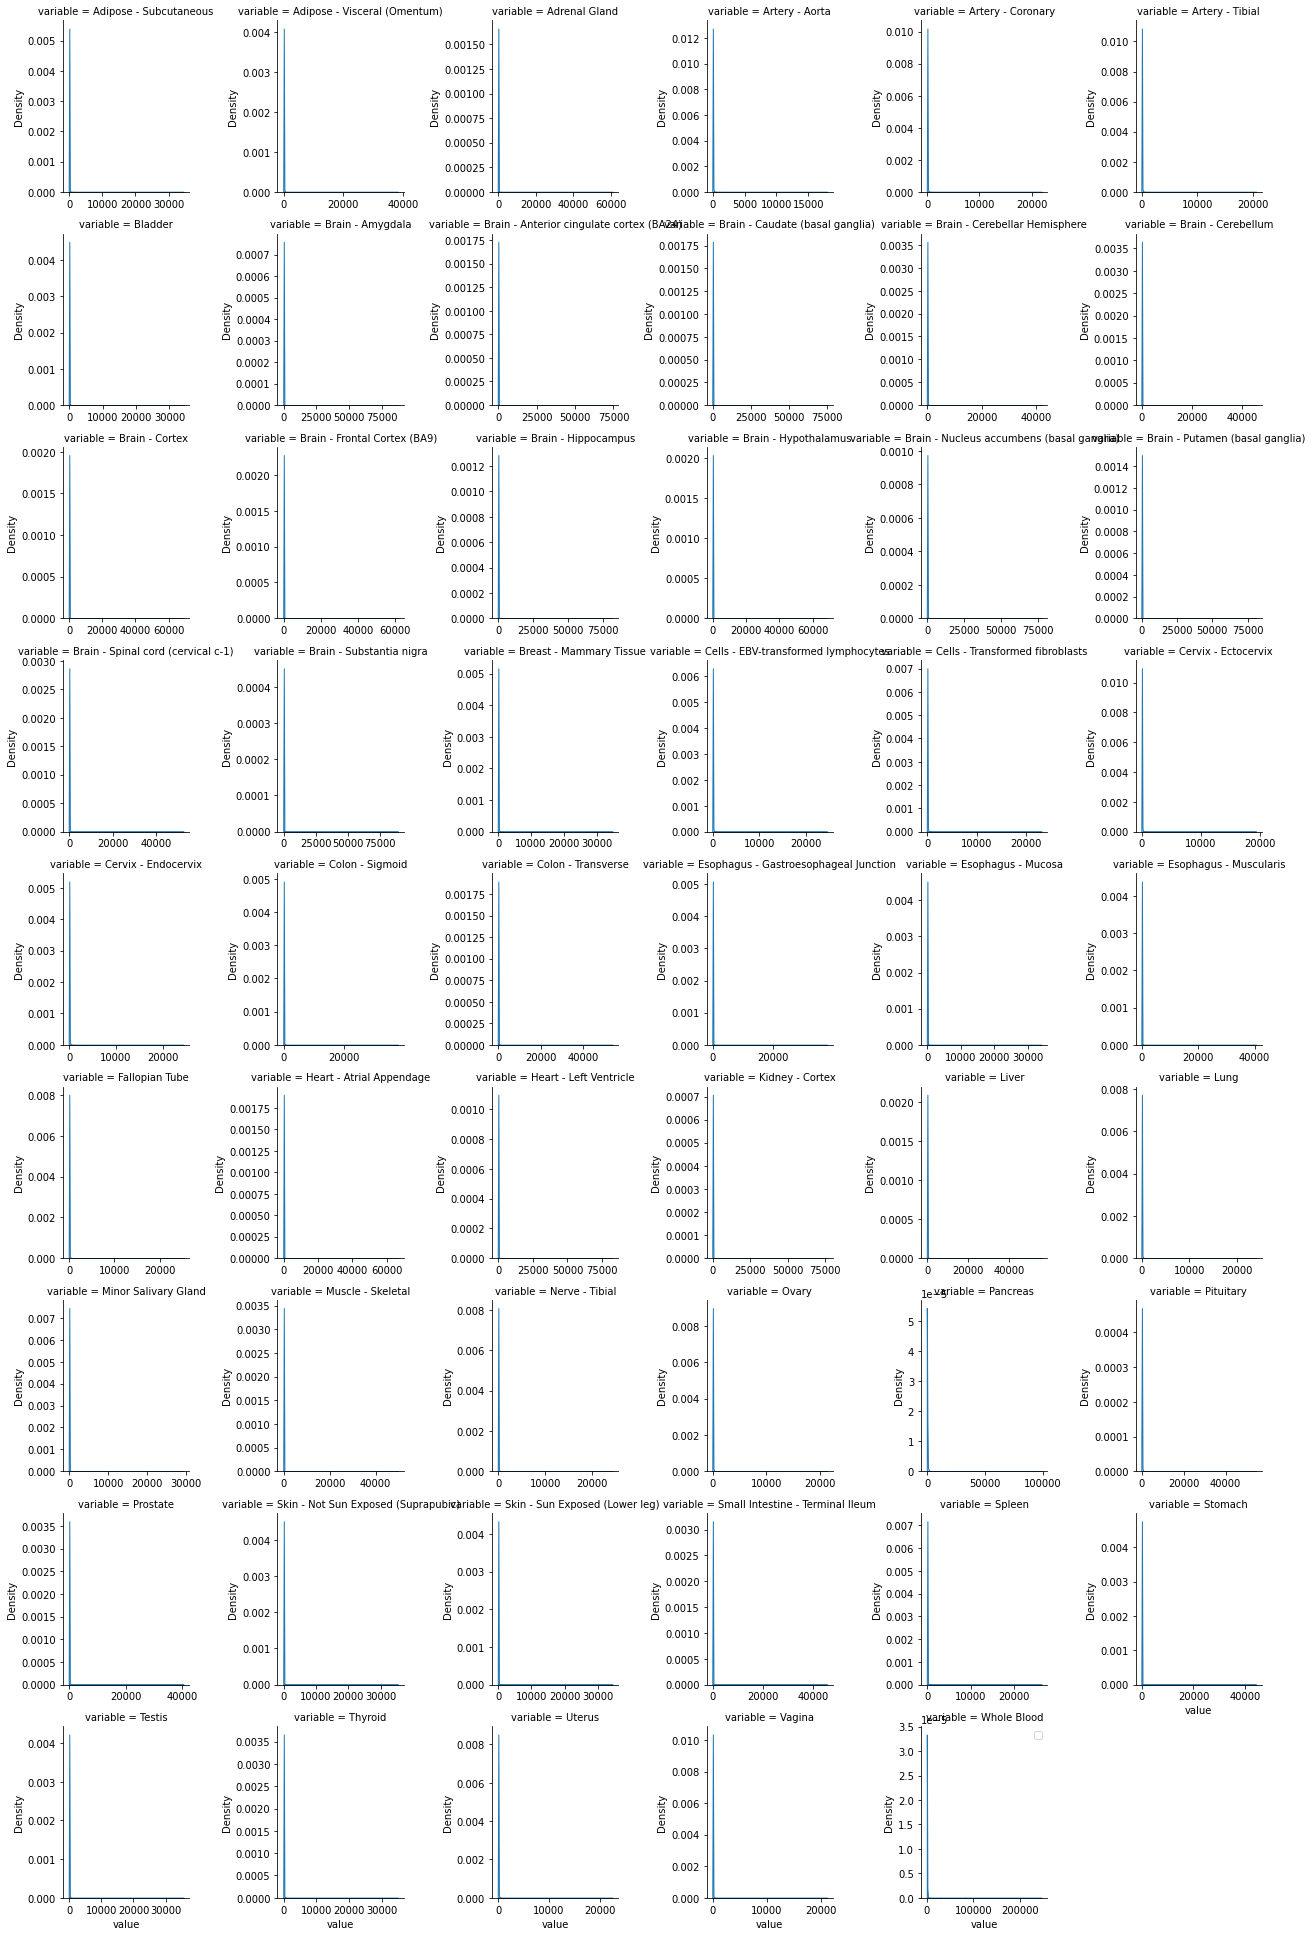

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

g = sns.FacetGrid(df.melt(),col="variable", col_wrap=6, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
#g.map(sns.histplot, "values", stat="frequency")
plt.show()

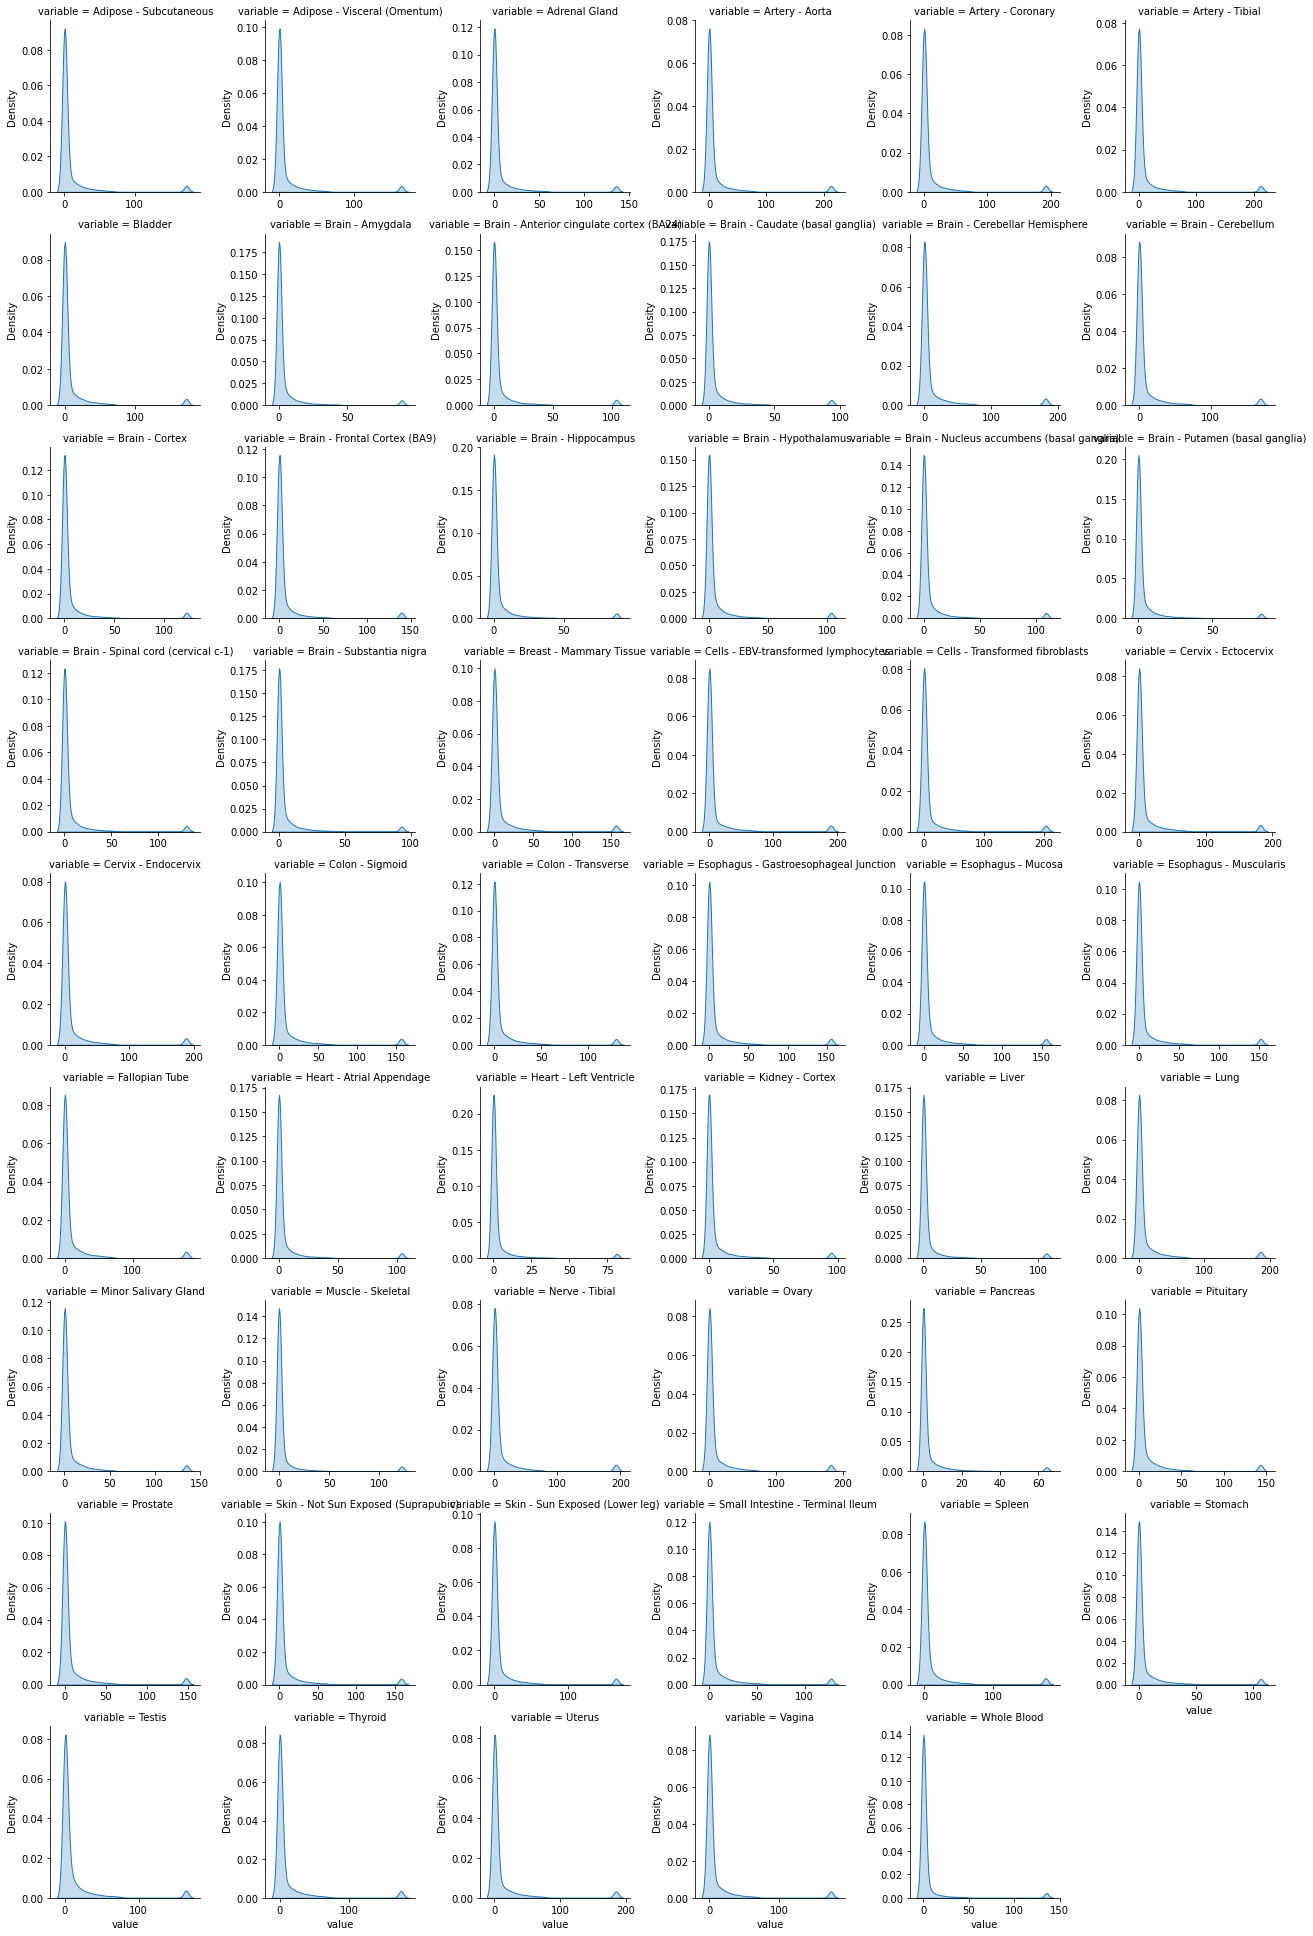

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

g = sns.FacetGrid(clip_df(df).melt(), col="variable", col_wrap=6, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
#g.map(sns.histplot, "values", stat="frequency")
plt.show()

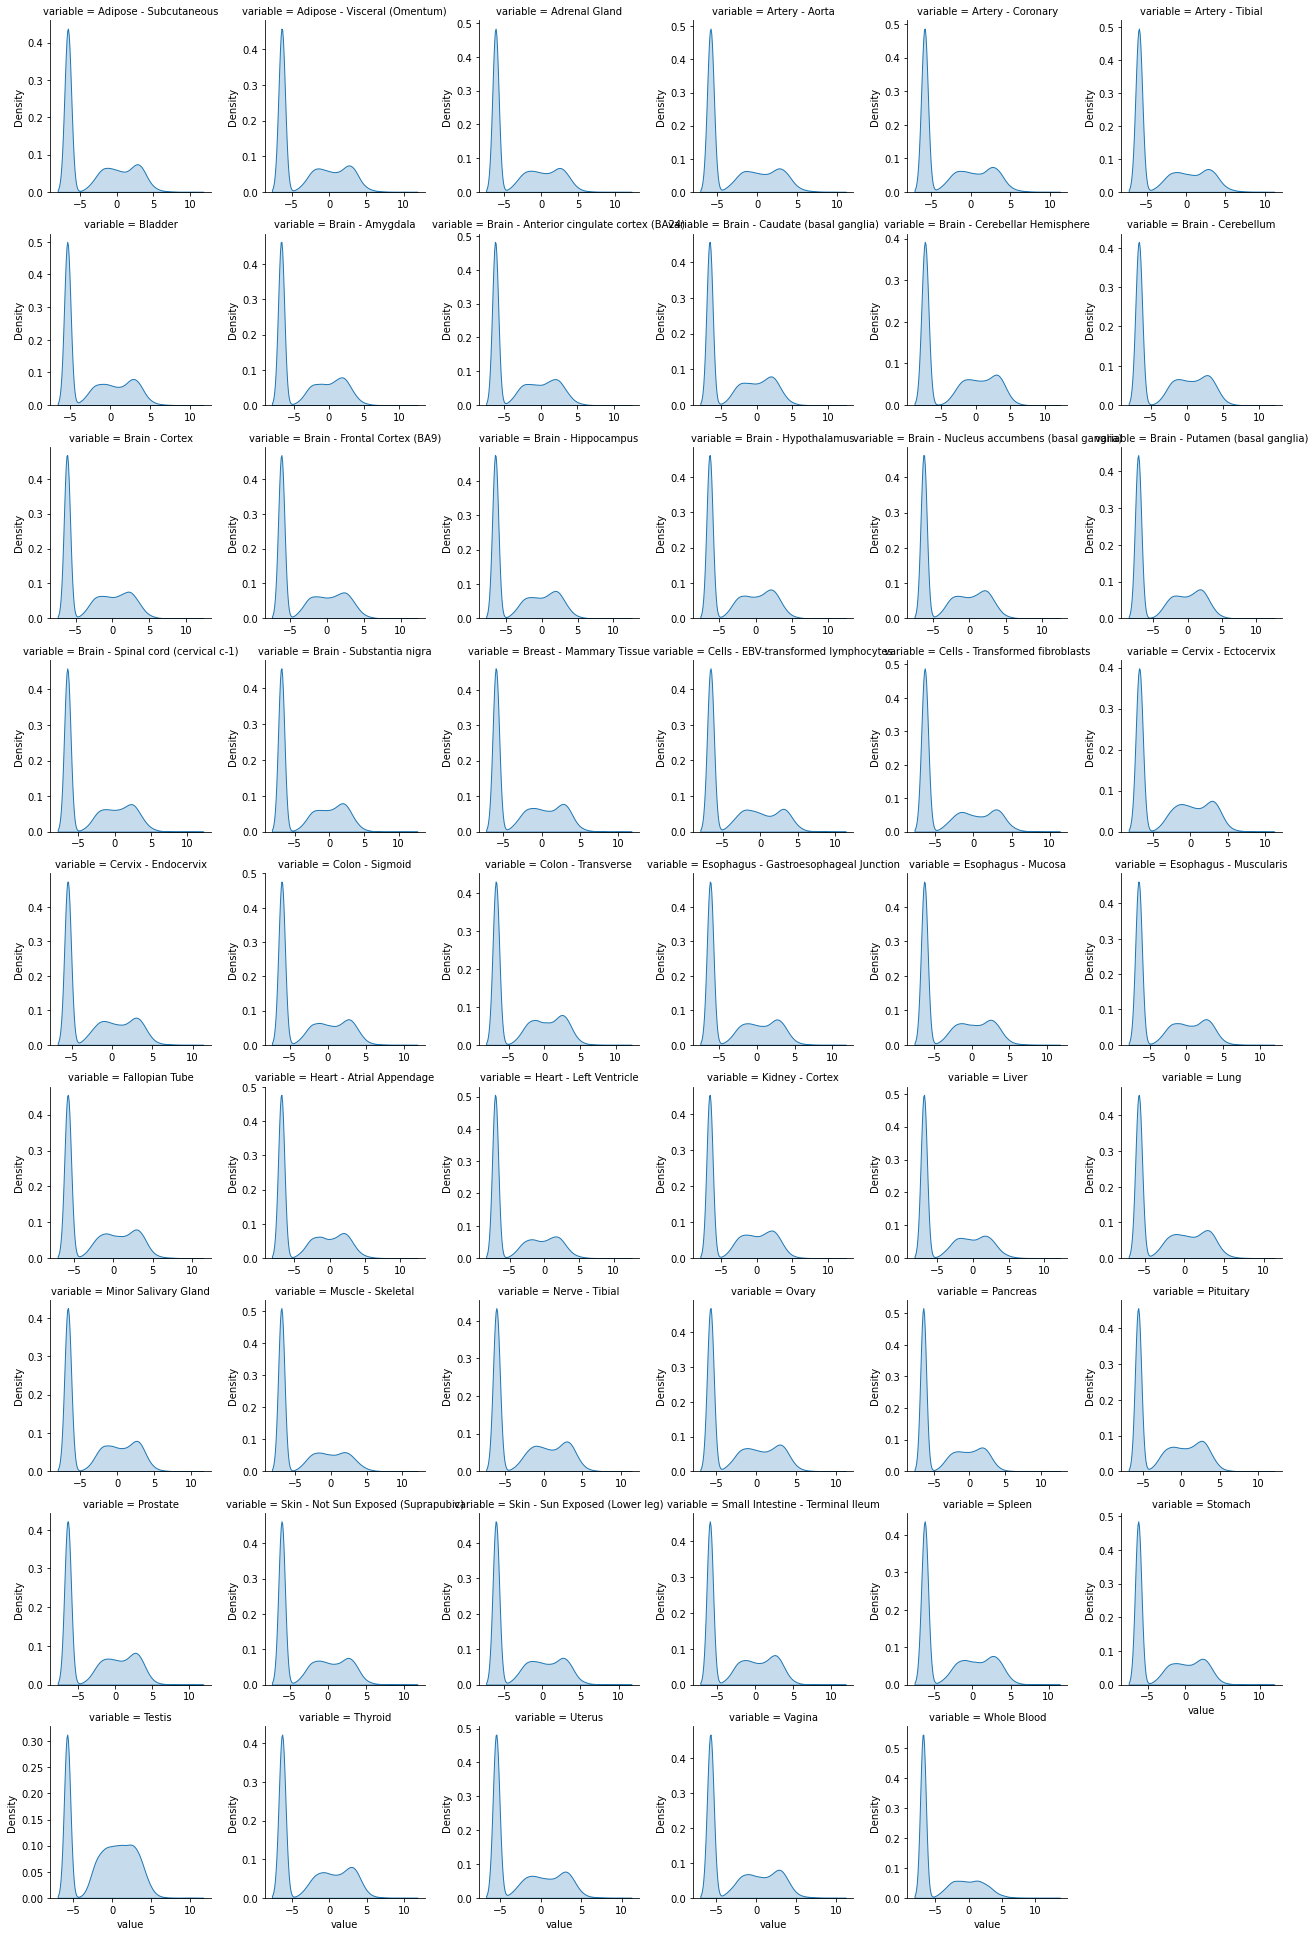

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

g = sns.FacetGrid(np.log(df + df[df > 0].min()).melt(), col="variable", col_wrap=6, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
#g.map(sns.histplot, "values", stat="frequency")
plt.show()

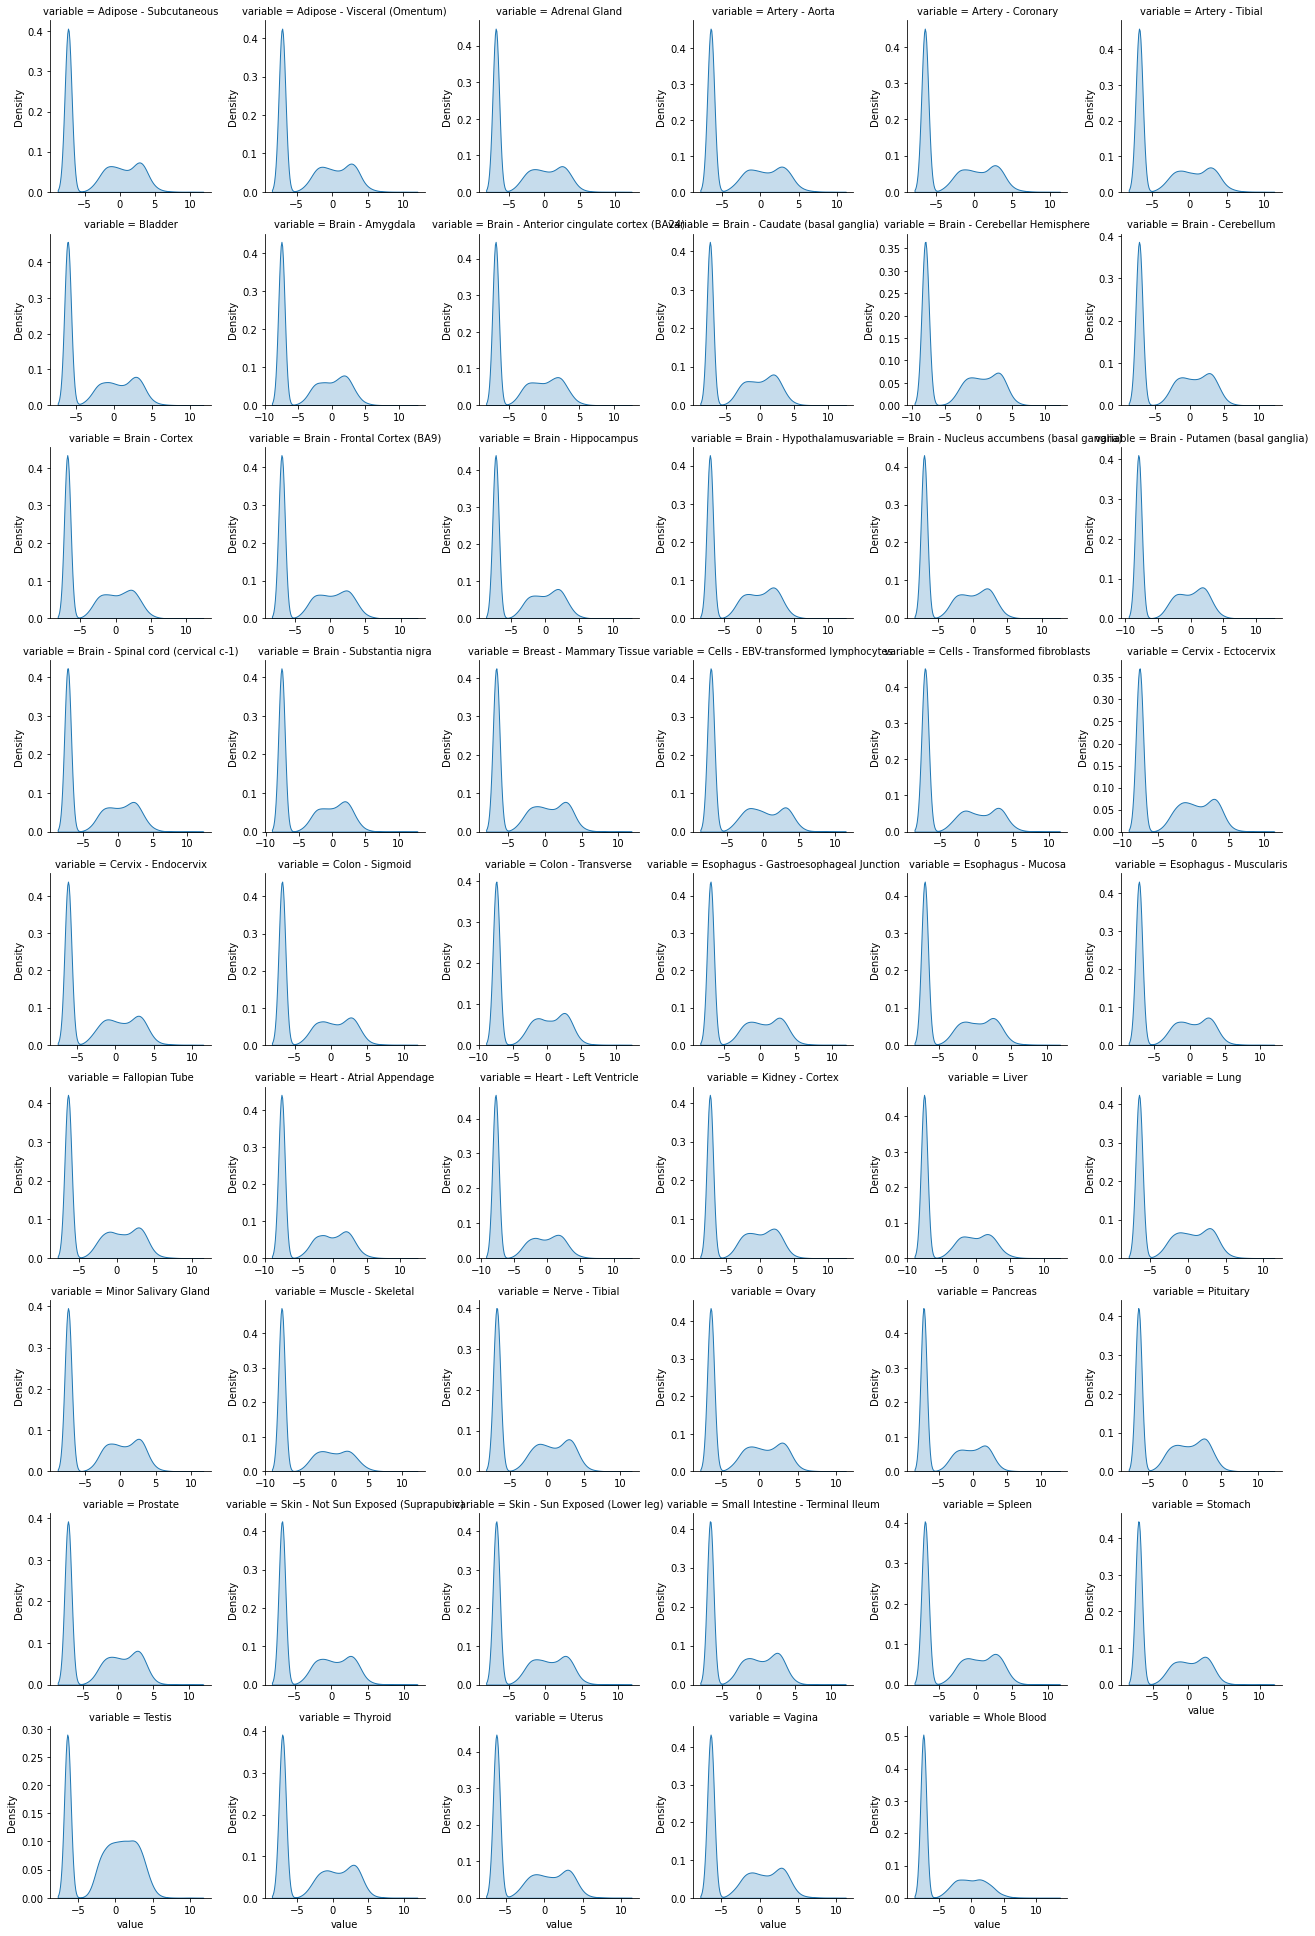

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

g = sns.FacetGrid(np.log(df + (df[df > 0].min() / 2)).melt(), col="variable", col_wrap=6, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
#g.map(sns.histplot, "values", stat="frequency")
plt.show()

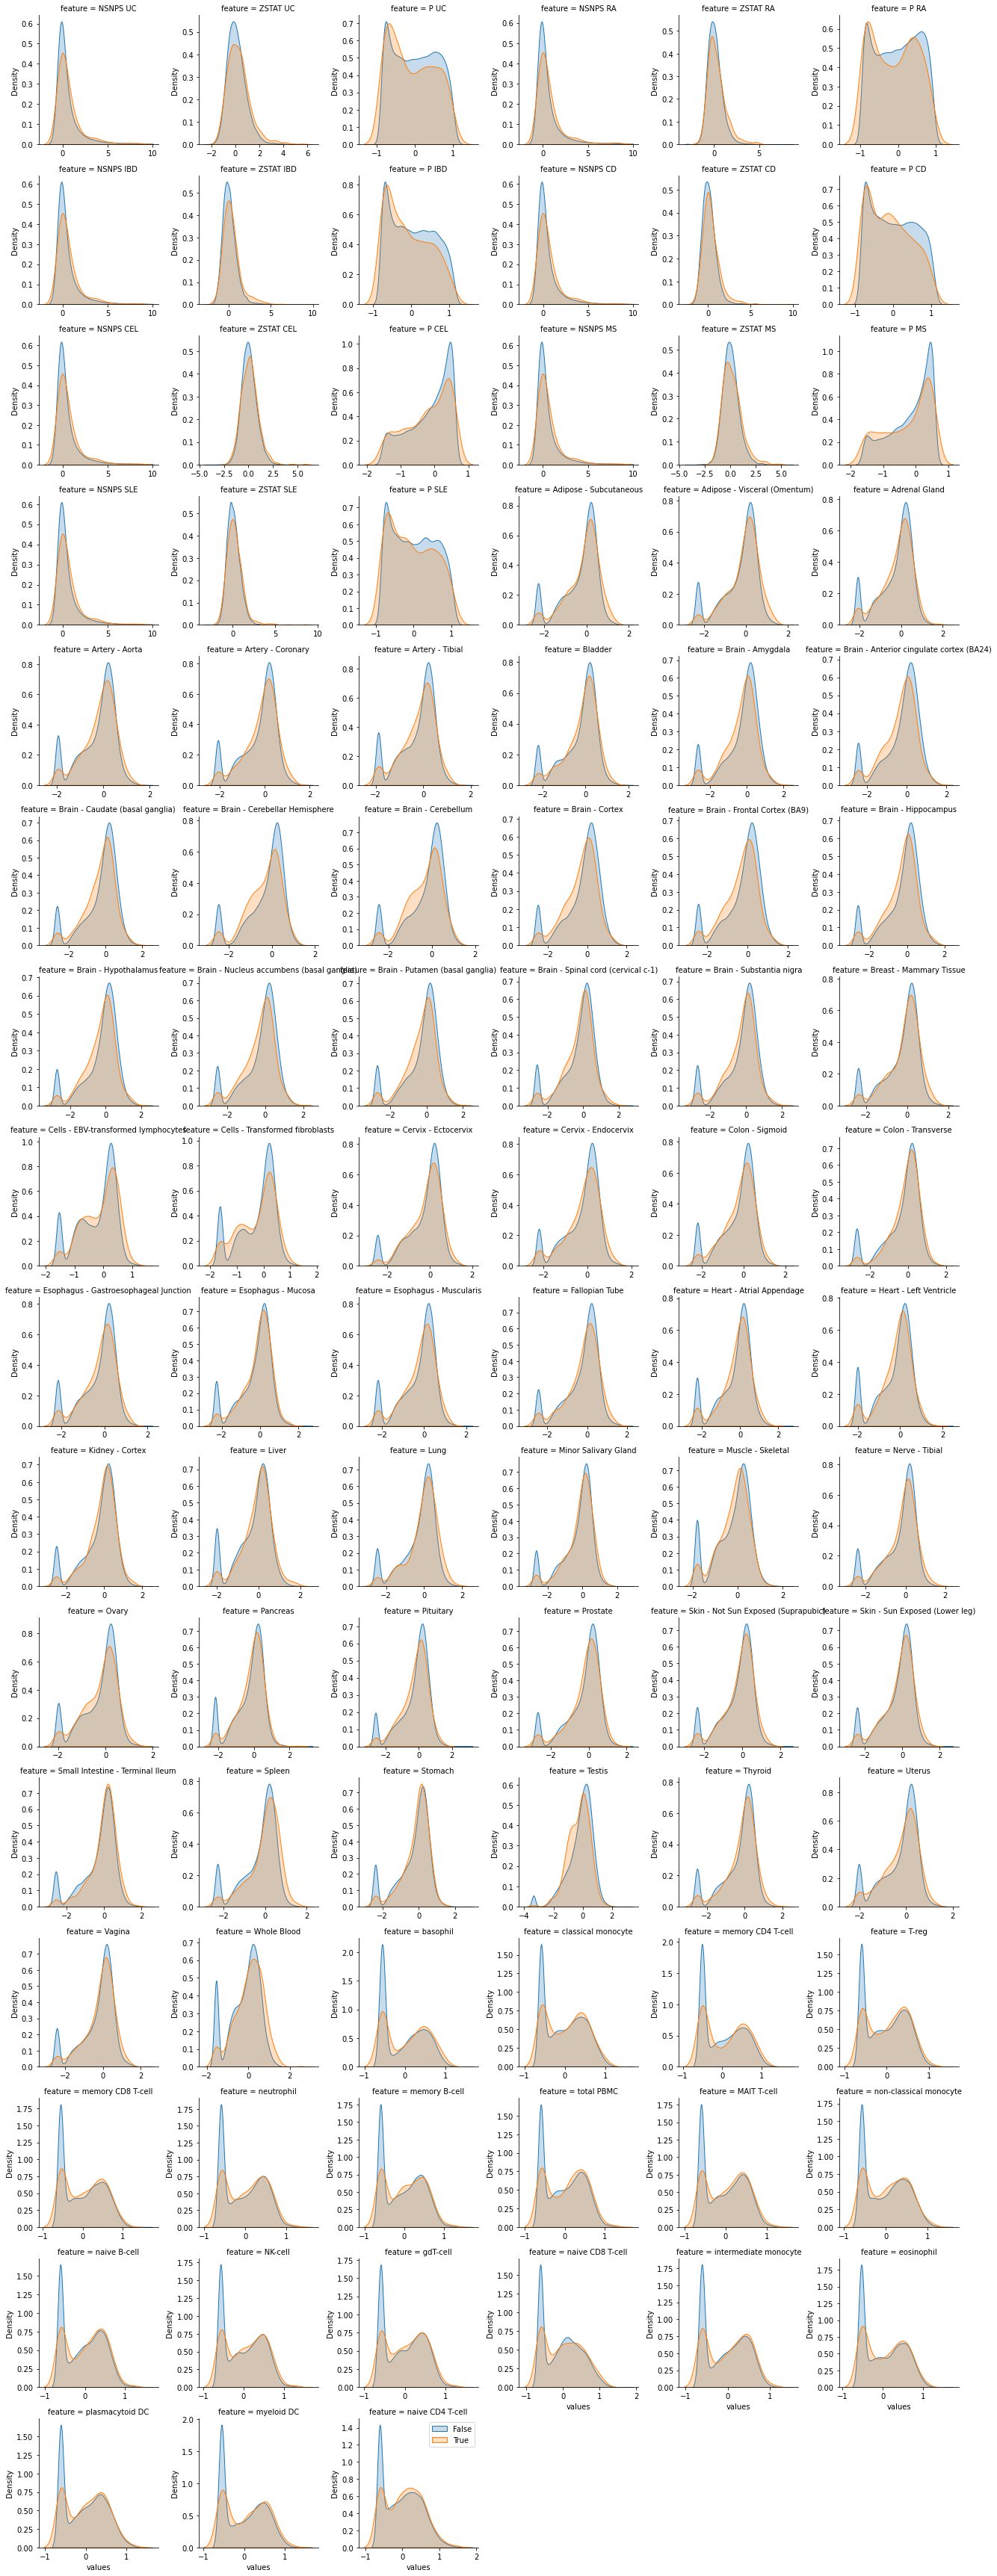

In [13]:
import seaborn as sns

g = sns.FacetGrid(x_df,col="feature", col_wrap=6, hue="is_positive", sharex=False, sharey=False)
g.map(sns.kdeplot, "values", shade=True, clip=(-10,10))
#g.map(sns.histplot, "values", stat="frequency")
plt.legend()
plt.show()

AttributeError: 'MultiGraph' object has no attribute 'random_walks'

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

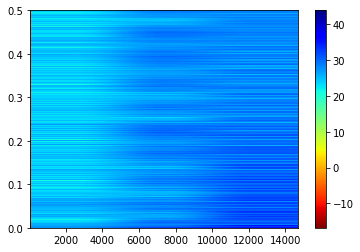

In [15]:
plt.specgram(X[:,55], NFFT=5000, Fs=1, cmap="jet_r")
plt.colorbar()
plt.show()

In [6]:
graph = preprocessor.G
preprocessor.add_y_label()
pos_ids, neg_ids = preprocessor.find_pos_and_neg_idx()

In [7]:
#first_order_neighborhoods = [list(graph.neighbors(pos_id)) for pos_id in pos_ids]

first_order_neighborhoods = [list(graph.predecessors(pos_id)) for pos_id in pos_ids]

In [8]:
#second_order_neighborhoods = [[list(graph.neighbors(first_order_neighbor)) for first_order_neighbor in neighborhood] for neighborhood in first_order_neighborhoods]

second_order_neighborhoods = [[list(graph.predecessors(first_order_neighbor)) for first_order_neighbor in neighborhood] for neighborhood in first_order_neighborhoods]

In [9]:
times_yes = 0
times_no = 0
# remove center nodes from second order neighborhoods (second run should show times_yes == 0)
for neighborhood, pos_id in zip(second_order_neighborhoods, pos_ids):
    for second_neighborhood in neighborhood:
        if pos_id in second_neighborhood:
            second_neighborhood.remove(pos_id)
            times_yes += 1
        else:
            times_no += 1

In [10]:
flattened_second_order_neighborhoods = [[i for node in neighborhood for i in node] for neighborhood in second_order_neighborhoods]

In [11]:
len(flattened_second_order_neighborhoods)

525

In [43]:
np.where([len(neighborhood) for neighborhood in first_order_neighborhoods])

(array([  0,   1,   3,   4,   5,   7,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
         45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  58,
         59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
        100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 114,
        115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 126, 127, 128,
        129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        157, 158, 159, 160, 161, 162, 164, 165, 167, 168, 169, 170, 171,
        172, 173, 174, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
        186, 187, 188, 189, 190, 191, 192, 193, 194

In [16]:
first_order_neighborhoods[94]

[3692]

In [15]:
import networkx as nx
nx.info(graph)

graph[pos_ids[0]]

AdjacencyView({})

In [85]:
one_so_neighborhood[:, 0].shape

(118,)

In [25]:
import seaborn as sns

# one pos node at a time, one feature at a time

feature_idx = 0
pose_node_idx = 2

one_pos_node = X[pos_ids[pose_node_idx], :]
one_fo_neighborhood = X[first_order_neighborhoods[pose_node_idx], :]
one_so_neighborhood = X[flattened_second_order_neighborhoods[pose_node_idx], :]


df = pd.DataFrame(np.hstack((one_pos_node[feature_idx], one_fo_neighborhood[:, feature_idx], one_so_neighborhood[:, feature_idx])), columns=["y"])
items = [["Center"], ["1 Hop"] * len(one_fo_neighborhood[:, feature_idx]), ["2 Hops"] * len(one_so_neighborhood[:, feature_idx])]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x",y="y")

medians = [np.median(values) for values in [[one_pos_node[feature_idx]], one_fo_neighborhood[:, feature_idx], one_so_neighborhood[:, feature_idx]]]
nobs = [1, len(first_order_neighborhoods[pose_node_idx]), len(flattened_second_order_neighborhoods[pose_node_idx])]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color=color,
            weight='semibold')

plt.show()

NameError: name 'pd' is not defined

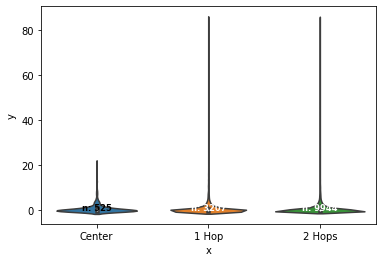

In [134]:
import pandas as pd
# all pos nodes at a time, one feature at a time

feature_idx = 6

flattened_first_order_neighborhoods = list(set([i for j in first_order_neighborhoods for i in j]))
flattened_flattened_second_order_neighborhoods = list(set([i for j in flattened_second_order_neighborhoods for i in j]))

pos_nodes = X[pos_ids, :]
fo_neighborhood = X[flattened_first_order_neighborhoods, :]
so_neighborhood = X[flattened_flattened_second_order_neighborhoods, :]


df = pd.DataFrame(np.hstack((pos_nodes[:, feature_idx], fo_neighborhood[:, feature_idx], so_neighborhood[:, feature_idx])), columns=["y"])
items = [["Center"] * len(pos_nodes[:, feature_idx]), ["1 Hop"] * len(fo_neighborhood[:, feature_idx]), ["2 Hops"] * len(so_neighborhood[:, feature_idx])]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x",y="y")



medians = [np.median(values) for values in [[pos_nodes[feature_idx]], fo_neighborhood[:, feature_idx], so_neighborhood[:, feature_idx]]]
nobs = [len(pos_nodes), len(flattened_first_order_neighborhoods), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color=color,
            weight='semibold')

plt.show()


In [143]:
# looking at change per hop, one center node and one feature at a time
import networkx as nx

feature_idx = 0
pose_node_idx = 0

flattened_first_order_neighborhoods = list(set([i for j in first_order_neighborhoods for i in j]))
flattened_flattened_second_order_neighborhoods = list(set([i for j in flattened_second_order_neighborhoods for i in j]))

one_pos_node = X[pos_ids[pose_node_idx], :]
one_fo_neighborhood = X[first_order_neighborhoods[pose_node_idx], :]
one_so_neighborhood = X[flattened_second_order_neighborhoods[pose_node_idx], :]

G = nx.DiGraph()
first_order_edges = [[pos_ids[pose_node_idx], neighbor] for neighbor in first_order_neighborhoods[pose_node_idx]]
second_order_edges = [[[first_order, second_order] for second_order in flattened_second_order_neighborhoods[pose_node_idx]] for first_order in first_order_neighborhoods[pose_node_idx]]
flattened_second_order_edges = [i for j in second_order_edges for i in j]

G.add_edges_from(first_order_edges + flattened_second_order_edges)

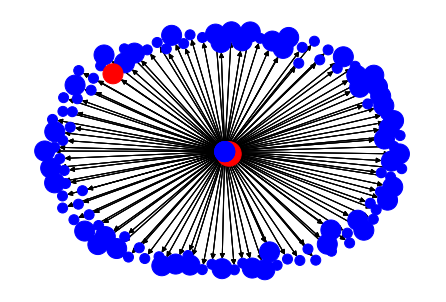

In [151]:

node_color = ["red" if node in pos_ids else "blue" for node in G.nodes]

node_size_dict = dict()
[node_size_dict.update({node_id: 100}) for node_id in flattened_flattened_second_order_neighborhoods]
[node_size_dict.update({node_id: 400}) for node_id in flattened_first_order_neighborhoods]
node_size_dict.update({pos_ids[pose_node_idx]: 600})

node_size = [node_size_dict[node] for node in G.nodes]
nx.draw(G, pos=nx.spring_layout(G), node_color=node_color,node_size=node_size)

Text(0, 0.5, 'Value for ZSTAT UC')

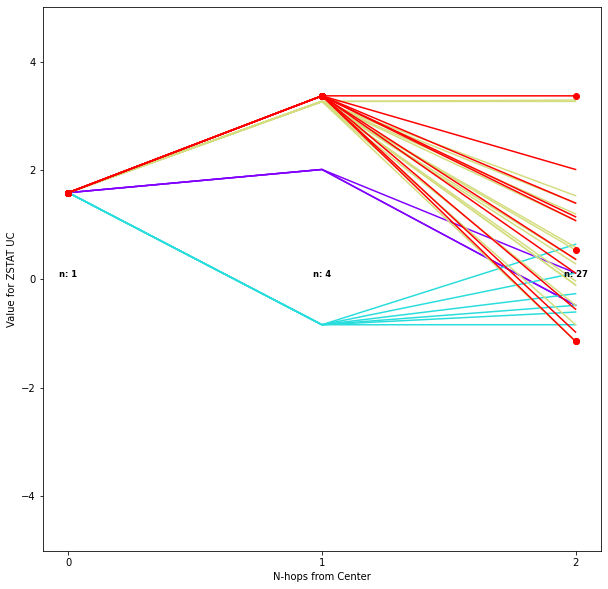

In [44]:
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib.pyplot import cm

# Zstat Cel and 7 is interesting

feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pos_node_idx = 7
center_node = pos_ids[pos_node_idx]
fo_neighborhood = first_order_neighborhoods[pos_node_idx]
so_neighborhoods = second_order_neighborhoods[pos_node_idx]

is_positive = []
color = cm.rainbow(np.linspace(0, 1, len(fo_neighborhood)))
colors = []
lines=[]
for i, fo_neighbor in enumerate(fo_neighborhood):
    if len(so_neighborhoods[i]) > 0:
        for j, so_neighbor in enumerate(so_neighborhoods[i]):
            colors.append(color[i])
            lines.append(np.asarray([X[center_node, feature_idx], X[fo_neighbor, feature_idx], X[so_neighbor, feature_idx]]))
            is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, so_neighbor in pos_ids])
    else:
        colors.append(color[i])
        lines.append(np.asarray([X[center_node, feature_idx], X[fo_neighbor, feature_idx], np.nan]))
        is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, False])

for i, line in enumerate(lines):
    ax = plt.plot([0,1,2], line, c=colors[i])
    
for i, nodes in enumerate(is_positive):
    if any(nodes):
        for j, positive in enumerate(nodes):
            if positive:
                plt.scatter(x=j, y=lines[i][j], c='r', label='Positive', zorder=2)



flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

nobs = [1, len(fo_neighborhood), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos= [0,1,2]

for tick in pos:
    plt.text(pos[tick], 0 + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.xlabel("N-hops from Center")
plt.xticks([0,1,2])
plt.ylim((-5,5))
plt.ylabel("Value for {}".format(feature_name))

In [59]:
np.asarray(lines)[:,2].max()

4.790324123418327

(array([3]),)


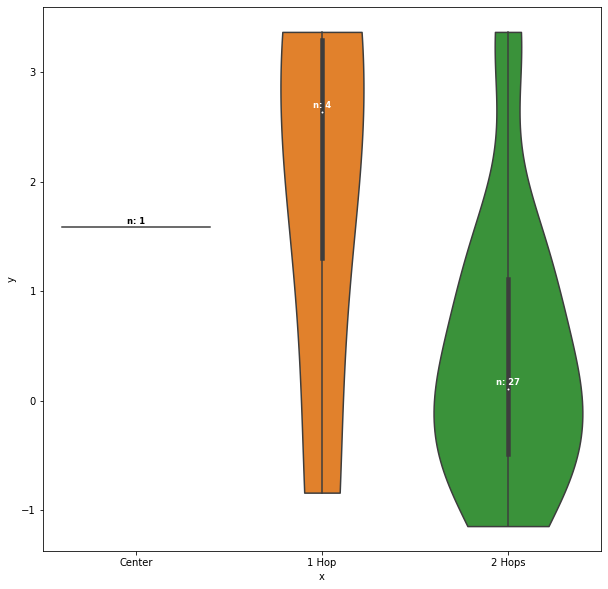

In [45]:
import seaborn as sns
import pandas as pd
# one pos node at a time, one feature at a time


feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pos_node_idx = 7

one_pos_node = X[pos_ids[pos_node_idx], feature_idx]
one_fo_neighborhood = X[first_order_neighborhoods[pos_node_idx], feature_idx]
one_so_neighborhood = X[flattened_second_order_neighborhoods[pos_node_idx], feature_idx]

print(np.where(one_fo_neighborhood == one_fo_neighborhood.max()))

fo_neighborhood = first_order_neighborhoods[pos_node_idx]
so_neighborhoods = second_order_neighborhoods[pos_node_idx]

df = pd.DataFrame(np.hstack((one_pos_node, one_fo_neighborhood, one_so_neighborhood)), columns=["y"])
items = [["Center"], ["1 Hop"] * len(one_fo_neighborhood), ["2 Hops"] * len(one_so_neighborhood)]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x", y="y", cut=0)

flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

medians = [np.median(values) for values in [[one_pos_node], one_fo_neighborhood, one_so_neighborhood]]
nobs = [1, len(first_order_neighborhoods[pos_node_idx]), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color=color,
            weight='semibold')

plt.show()

In [38]:
previous_shape = real_adj.shape
real_adj = real_adj.flatten()
np.random.shuffle(real_adj)

In [12]:

real_adj = np.zeros((len(y), len(y)))

for i, j in zip(*adj[list(adj.keys())[0]]):
    real_adj[i, j] = 1

In [13]:
A_plus_I = real_adj + np.diag(np.ones(real_adj.shape[0]))
degrees = np.sum(A_plus_I,axis=0)
D = np.diag(np.power(degrees, -0.5))
L = np.multiply(D, A_plus_I)
L_norm = np.multiply(L, D)


In [14]:
X_transformed = np.matmul(L_norm, X)

Text(0, 0.5, 'Value for ZSTAT UC')

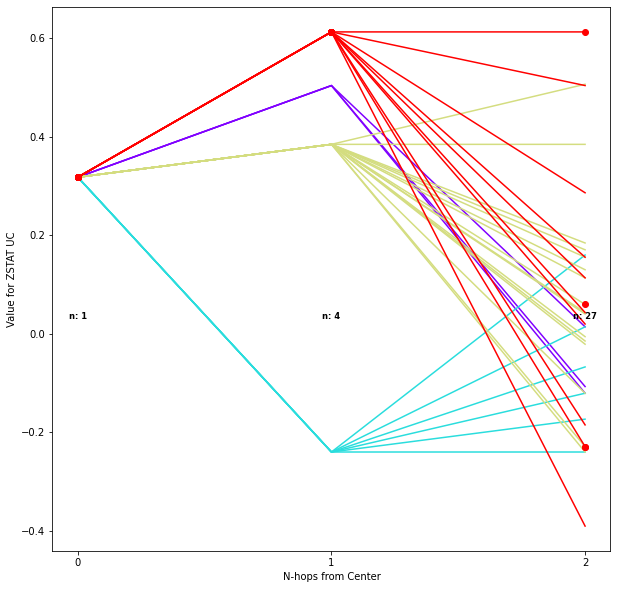

In [49]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib.pyplot import cm

# Zstat Cel and 7 is interesting

feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pose_node_idx = 7
center_node = pos_ids[pose_node_idx]
fo_neighborhood = first_order_neighborhoods[pose_node_idx]
so_neighborhoods = second_order_neighborhoods[pose_node_idx]

is_positive = []
color = cm.rainbow(np.linspace(0, 1, len(fo_neighborhood)))
colors = []
lines=[]
for i, fo_neighbor in enumerate(fo_neighborhood):
    if len(so_neighborhoods[i]) > 0:
        for j, so_neighbor in enumerate(so_neighborhoods[i]):
            colors.append(color[i])
            lines.append(np.asarray([X_transformed[center_node, feature_idx], X_transformed[fo_neighbor, feature_idx], X_transformed[so_neighbor, feature_idx]]))
            is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, so_neighbor in pos_ids])
    else:
        colors.append(color[i])
        lines.append(np.asarray([X_transformed[center_node, feature_idx], X_transformed[fo_neighbor, feature_idx], np.nan]))
        is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, False])

for i, line in enumerate(lines):
    ax = plt.plot([0,1,2], line, c=colors[i])
    
for i, nodes in enumerate(is_positive):
    if any(nodes):
        for j, positive in enumerate(nodes):
            if positive:
                plt.scatter(x=j, y=lines[i][j], c='r', label='Positive', zorder=2)



flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

nobs = [1, len(fo_neighborhood), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos= [0,1,2]

for tick in pos:
    plt.text(pos[tick], 0 + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.xlabel("N-hops from Center")
plt.xticks([0,1,2])
plt.ylabel("Value for {}".format(feature_name))

(array([3]),)


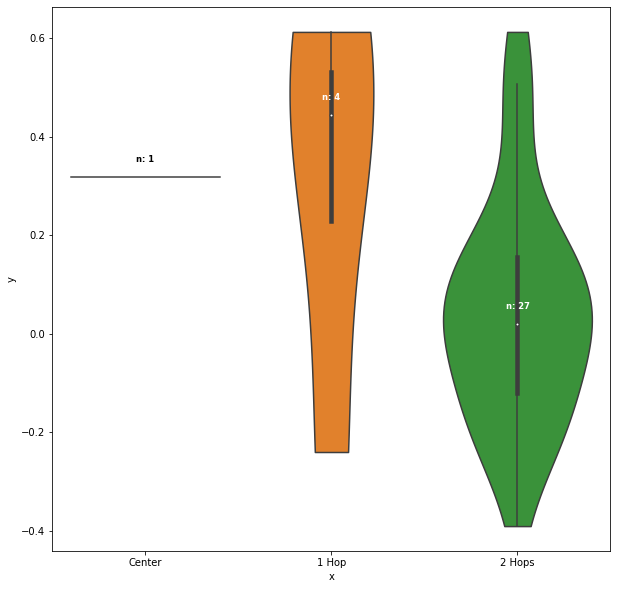

In [50]:
import seaborn as sns

# one pos node at a time, one feature at a time


feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pos_node_idx = 7

one_pos_node = X_transformed[pos_ids[pose_node_idx], feature_idx]
one_fo_neighborhood = X_transformed[first_order_neighborhoods[pos_node_idx], feature_idx]
one_so_neighborhood = X_transformed[flattened_second_order_neighborhoods[pos_node_idx], feature_idx]

print(np.where(one_fo_neighborhood == one_fo_neighborhood.max()))

fo_neighborhood = first_order_neighborhoods[pos_node_idx]
so_neighborhoods = second_order_neighborhoods[pos_node_idx]

df = pd.DataFrame(np.hstack((one_pos_node, one_fo_neighborhood, one_so_neighborhood)), columns=["y"])
items = [["Center"], ["1 Hop"] * len(one_fo_neighborhood), ["2 Hops"] * len(one_so_neighborhood)]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x", y="y", cut=0)

flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

medians = [np.median(values) for values in [[one_pos_node], one_fo_neighborhood, one_so_neighborhood]]
nobs = [1, len(first_order_neighborhoods[pos_node_idx]), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color=color,
            weight='semibold')

plt.show()

In [15]:


X_transformed_2  = np.matmul(L_norm, X_transformed)

Text(0, 0.5, 'Value for ZSTAT UC')

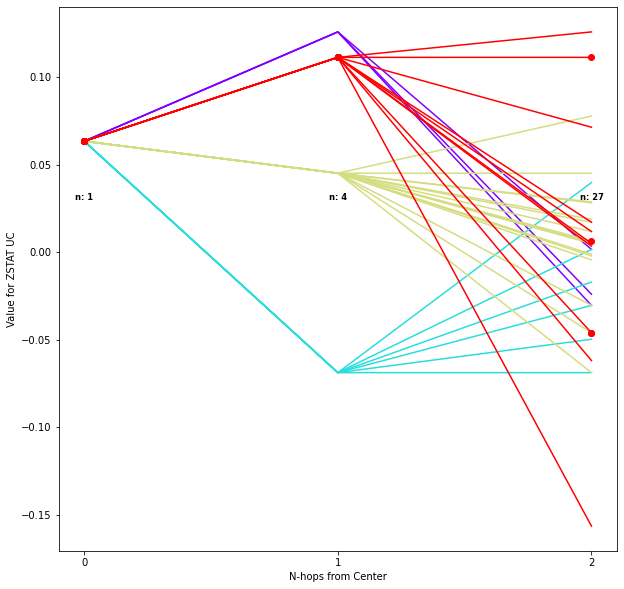

In [52]:
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib.pyplot import cm

# Zstat Cel and 7 is interesting

feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pose_node_idx = 7
center_node = pos_ids[pose_node_idx]
fo_neighborhood = first_order_neighborhoods[pose_node_idx]
so_neighborhoods = second_order_neighborhoods[pose_node_idx]

is_positive = []
color = cm.rainbow(np.linspace(0, 1, len(fo_neighborhood)))
colors = []
lines=[]
for i, fo_neighbor in enumerate(fo_neighborhood):
    for j, so_neighbor in enumerate(so_neighborhoods[i]):
        colors.append(color[i])
        lines.append([X_transformed_2[center_node, feature_idx], X_transformed_2[fo_neighbor, feature_idx], X_transformed_2[so_neighbor, feature_idx]])
        is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, so_neighbor in pos_ids])

for i, line in enumerate(lines):
    ax = plt.plot([0,1,2], line, c=colors[i])
    
for i, nodes in enumerate(is_positive):
    if any(nodes):
        for j, positive in enumerate(nodes):
            if positive:
                plt.scatter(x=j, y=lines[i][j], c='r', label='Positive', zorder=2)



flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

nobs = [1, len(fo_neighborhood), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos= [0,1,2]

for tick in pos:
    plt.text(pos[tick], 0 + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.xlabel("N-hops from Center")
plt.xticks([0,1,2])
#plt.ylim((-5,5))
plt.ylabel("Value for {}".format(feature_name))

In [60]:
# check if we have adjacency in the right way 

assert set(np.where(real_adj[pos_ids[94], :])[0].tolist()) == set(first_order_neighborhoods[94])

(array([0]),)


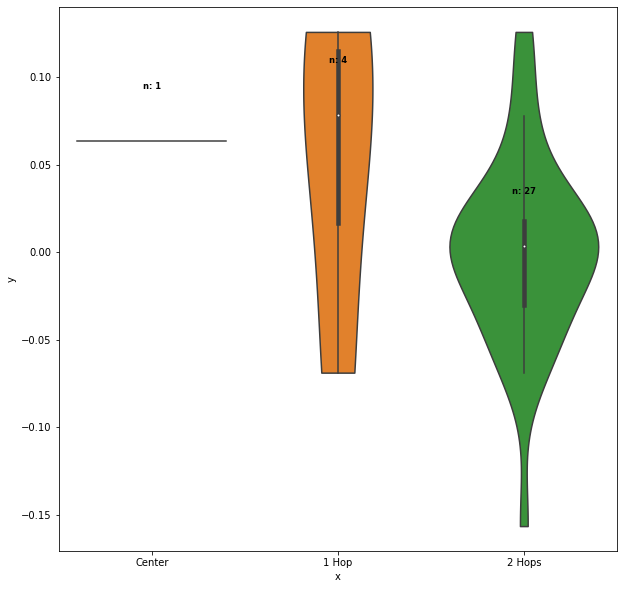

In [53]:
import seaborn as sns

# one pos node at a time, one feature at a time


feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pos_node_idx = 7

one_pos_node = X_transformed_2[pos_ids[pose_node_idx], feature_idx]
one_fo_neighborhood = X_transformed_2[first_order_neighborhoods[pos_node_idx], feature_idx]
one_so_neighborhood = X_transformed_2[flattened_second_order_neighborhoods[pos_node_idx], feature_idx]

print(np.where(one_fo_neighborhood == one_fo_neighborhood.max()))

fo_neighborhood = first_order_neighborhoods[pos_node_idx]
so_neighborhoods = second_order_neighborhoods[pos_node_idx]

df = pd.DataFrame(np.hstack((one_pos_node, one_fo_neighborhood, one_so_neighborhood)), columns=["y"])
items = [["Center"], ["1 Hop"] * len(one_fo_neighborhood), ["2 Hops"] * len(one_so_neighborhood)]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x", y="y", cut=0)

flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

medians = [np.median(values) for values in [[one_pos_node], one_fo_neighborhood, one_so_neighborhood]]
nobs = [1, len(first_order_neighborhoods[pos_node_idx]), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.show()

In [16]:


X_transformed_3  = np.matmul(L_norm, X_transformed_2)

Text(0, 0.5, 'Value for ZSTAT UC')

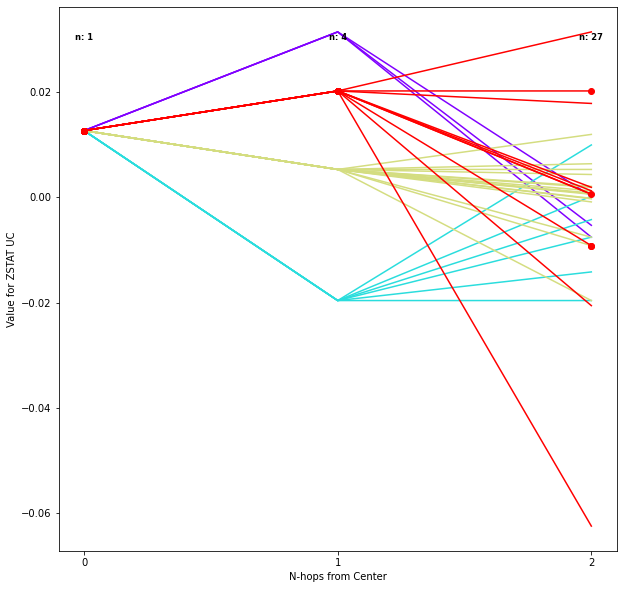

In [55]:
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib.pyplot import cm

# Zstat Cel and 7 is interesting

feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pose_node_idx = 7
center_node = pos_ids[pose_node_idx]
fo_neighborhood = first_order_neighborhoods[pose_node_idx]
so_neighborhoods = second_order_neighborhoods[pose_node_idx]

is_positive = []
color = cm.rainbow(np.linspace(0, 1, len(fo_neighborhood)))
colors = []
lines=[]
for i, fo_neighbor in enumerate(fo_neighborhood):
    for j, so_neighbor in enumerate(so_neighborhoods[i]):
        colors.append(color[i])
        lines.append([X_transformed_3[center_node, feature_idx], X_transformed_3[fo_neighbor, feature_idx], X_transformed_3[so_neighbor, feature_idx]])
        is_positive.append([center_node in pos_ids, fo_neighbor in pos_ids, so_neighbor in pos_ids])

for i, line in enumerate(lines):
    ax = plt.plot([0,1,2], line, c=colors[i])
    
for i, nodes in enumerate(is_positive):
    if any(nodes):
        for j, positive in enumerate(nodes):
            if positive:
                plt.scatter(x=j, y=lines[i][j], c='r', label='Positive', zorder=2)



flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

nobs = [1, len(fo_neighborhood), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos= [0,1,2]

for tick in pos:
    plt.text(pos[tick], 0 + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.xlabel("N-hops from Center")
plt.xticks([0,1,2])
#plt.ylim((-5,5))
plt.ylabel("Value for {}".format(feature_name))

(array([0]),)


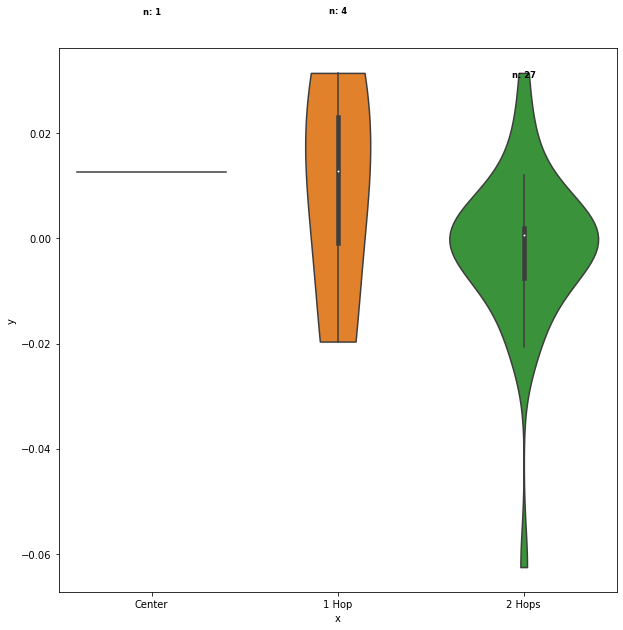

In [56]:
import seaborn as sns

# one pos node at a time, one feature at a time


feature_name = "ZSTAT UC"

feature_idx = feature_names.index(feature_name)
pos_node_idx = 7

one_pos_node = X_transformed_3[pos_ids[pose_node_idx], feature_idx]
one_fo_neighborhood = X_transformed_3[first_order_neighborhoods[pos_node_idx], feature_idx]
one_so_neighborhood = X_transformed_3[flattened_second_order_neighborhoods[pos_node_idx], feature_idx]

print(np.where(one_fo_neighborhood == one_fo_neighborhood.max()))

fo_neighborhood = first_order_neighborhoods[pos_node_idx]
so_neighborhoods = second_order_neighborhoods[pos_node_idx]

df = pd.DataFrame(np.hstack((one_pos_node, one_fo_neighborhood, one_so_neighborhood)), columns=["y"])
items = [["Center"], ["1 Hop"] * len(one_fo_neighborhood), ["2 Hops"] * len(one_so_neighborhood)]
df["x"] = [item for values in items for item in values]
ax = sns.violinplot(data=df, x="x", y="y", cut=0)

flattened_flattened_second_order_neighborhoods = list(set([i for j in so_neighborhoods for i in j]))

medians = [np.median(values) for values in [[one_pos_node], one_fo_neighborhood, one_so_neighborhood]]
nobs = [1, len(first_order_neighborhoods[pos_node_idx]), len(flattened_flattened_second_order_neighborhoods)]
nobs = ["n: " + str(i) for i in nobs]
pos=[0,1,2]

for tick, label in zip(pos, ax.get_xticklabels()):
    color = "w" if tick > 0 else "k"
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
            horizontalalignment='center',
            size='small',
            color="k",
            weight='semibold')

plt.show()

In [93]:
import walker

walks =walker.random_walks(preprocessor.G, n_walks=1, walk_len=20)

Random walks - T=0.27s


In [102]:
X[walks].shape

(17024, 20, 93)

In [64]:
flat_walks = walks.flatten()

In [103]:
from numpy import diff
dy = diff(X[walks], axis=1)

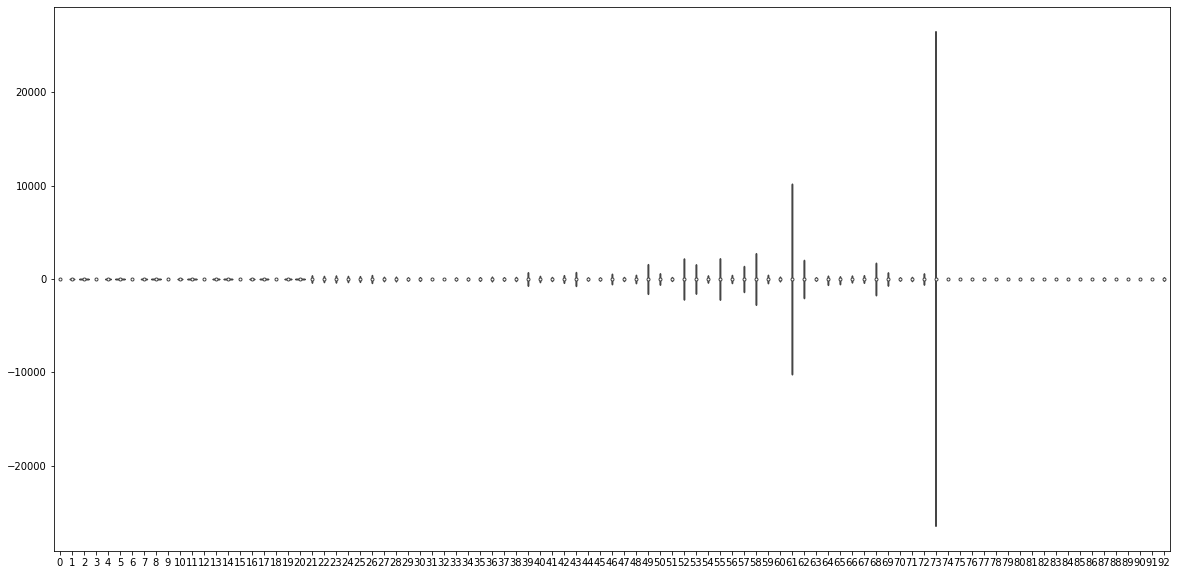

In [112]:
plt.rcParams['figure.figsize'] = [20, 10]
g = sns.violinplot(data=df)
plt.show()

In [114]:
feature_names[61]

'Pancreas'

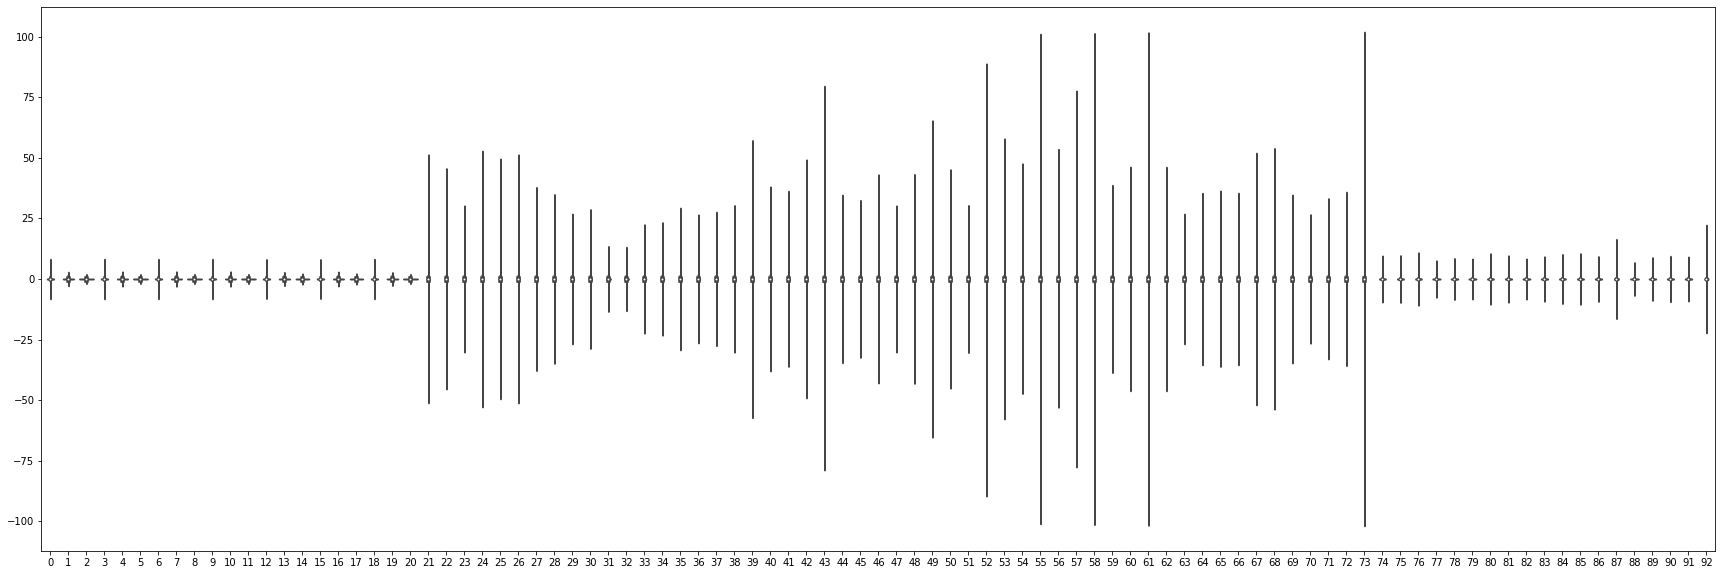

In [133]:
plt.rcParams['figure.figsize'] = [30, 10]
g = sns.violinplot(data=df[np.abs(stats.zscore(df)) < 3].clip(-100,100))
plt.show()

In [109]:
df = pd.DataFrame(dy.reshape(-1,dy.shape[-1]), columns=list(range(len(feature_names))))

In [104]:
dy.shape

(17024, 19, 93)

In [17]:
from coregenes.utils.metrics import MetricsHelper

indices = np.asarray(list(range(X.shape[0])))
y_truth = np.asarray([1 if index in pos_ids else 0 for index in indices])
metrics = MetricsHelper(y_truth, 0.5)

In [170]:
feature_names

['NSNPS UC',
 'ZSTAT UC',
 'P UC',
 'NSNPS RA',
 'ZSTAT RA',
 'P RA',
 'NSNPS IBD',
 'ZSTAT IBD',
 'P IBD',
 'NSNPS CD',
 'ZSTAT CD',
 'P CD',
 'NSNPS CEL',
 'ZSTAT CEL',
 'P CEL',
 'NSNPS MS',
 'ZSTAT MS',
 'P MS',
 'NSNPS SLE',
 'ZSTAT SLE',
 'P SLE',
 'Adipose - Subcutaneous',
 'Adipose - Visceral (Omentum)',
 'Adrenal Gland',
 'Artery - Aorta',
 'Artery - Coronary',
 'Artery - Tibial',
 'Bladder',
 'Brain - Amygdala',
 'Brain - Anterior cingulate cortex (BA24)',
 'Brain - Caudate (basal ganglia)',
 'Brain - Cerebellar Hemisphere',
 'Brain - Cerebellum',
 'Brain - Cortex',
 'Brain - Frontal Cortex (BA9)',
 'Brain - Hippocampus',
 'Brain - Hypothalamus',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Brain - Putamen (basal ganglia)',
 'Brain - Spinal cord (cervical c-1)',
 'Brain - Substantia nigra',
 'Breast - Mammary Tissue',
 'Cells - EBV-transformed lymphocytes',
 'Cells - Transformed fibroblasts',
 'Cervix - Ectocervix',
 'Cervix - Endocervix',
 'Colon - Sigmoid',
 'Colon - Tra

<function matplotlib.pyplot.show(close=None, block=None)>

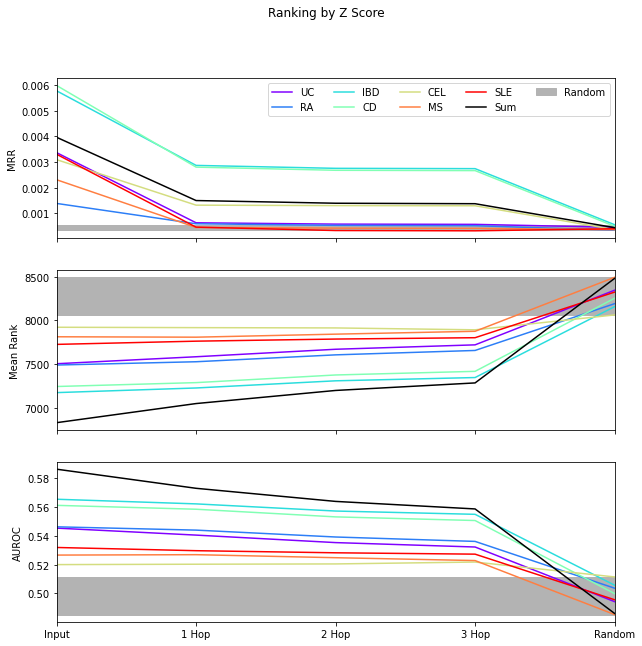

In [20]:
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [10, 10]

from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len([0,3,6,9,12,15,18])))
color = np.concatenate((color,np.asarray((0,0,0,1)).reshape(1,-1)))

fig, axes = plt.subplots(3,1, sharex=True)
patches = []
randoms = np.empty((len([0,3,6,9,12,15,18]) + 1, 3))

for j, features in enumerate([1,4,7,10,13,16,19,[1,4,7,10,13,16,19]]):
    feature_values = np.sum(X[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_0 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_1 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed_2[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_2 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed_3[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_3 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    random = np.mean(np.random.normal(size=X.shape[0] * 10).reshape(X.shape[0],-1), axis=1)
    metrics.update(random, "all")
    results_random = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    metrics_list = ["MRR", "Mean Rank", "AUROC"]

    results = np.vstack((results_0, results_1, results_2, results_3, results_random))

    for i in range(results.shape[1]):
        patch, = axes[i].plot(results[:, i], color=color[j])
        
        axes[i].set_ylabel(metrics_list[i])

    randoms[j, :] = results_random
    patches.append(patch)

for i in range(results.shape[1]):
    axes[i].fill_between(x=(-1,5), y1=np.max(randoms[:, i]), y2=np.min(randoms[:, i]), color=[(0.7,0.7,0.7,1)], zorder=-1)

patches.append(Patch(facecolor=(0.7,0.7,0.7,1), edgecolor=(0.7,0.7,0.7,1),
                         label='Random'))

legend_values = [feature_names[i][6:] for i in [1,4,7,10,13,16,19]] + ["Sum", "Random"]
axes[0].legend(patches, legend_values, loc='upper right', ncol=5)
plt.xlim((0,4))
plt.xticks([0,1,2,3,4],["Input", "1 Hop", "2 Hop", "3 Hop", "Random"])
plt.suptitle("Ranking by Z Score")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

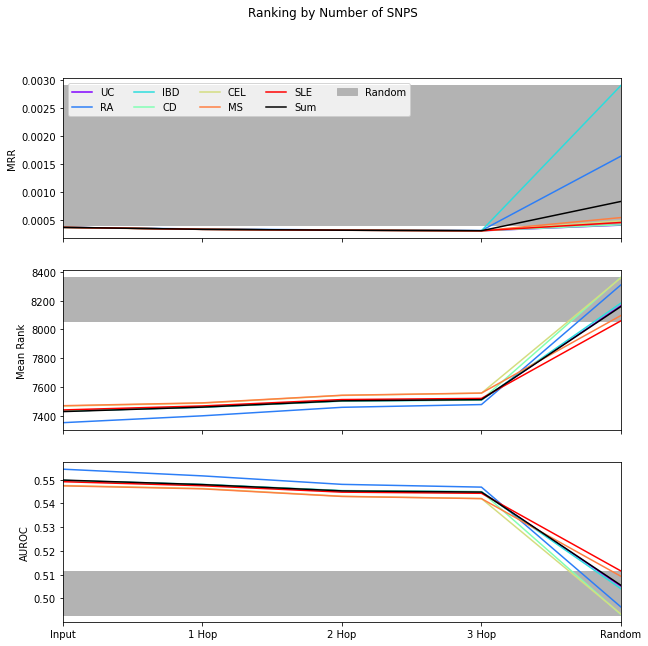

In [21]:
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [10, 10]

color = cm.rainbow(np.linspace(0, 1, len([0,3,6,9,12,15,18])))
color = np.concatenate((color,np.asarray((0,0,0,1)).reshape(1,-1)))

fig, axes = plt.subplots(3,1, sharex=True)
patches = []
randoms = np.empty((len([0,3,6,9,12,15,18]) + 1, 3))
for j, features in enumerate([0,3,6,9,12,15,18, [0,3,6,9,12,15,18]]):
    feature_values = np.sum(X[:,features].reshape(X.shape[0],-1), axis=1)
    #feature_values = X[:, 2]
    metrics.update(feature_values, "all")
    results_0 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_1 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed_2[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_2 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = np.sum(X_transformed_3[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_3 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    random = np.mean(np.random.normal(size=X.shape[0] * 10).reshape(X.shape[0],-1), axis=1)
    metrics.update(random, "all")
    results_random = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    metrics_list = ["MRR", "Mean Rank", "AUROC"]

    results = np.vstack((results_0, results_1, results_2, results_3, results_random))
    
    for i in range(results.shape[1]):
        patch,  = axes[i].plot(results[:, i], color=color[j])
        axes[i].set_ylabel(metrics_list[i])

    randoms[j, :] = results_random
    patches.append(patch)

for i in range(results.shape[1]):
    axes[i].fill_between(x=(-1,5), y1=np.max(randoms[:, i]), y2=np.min(randoms[:, i]), color=[(0.7,0.7,0.7,1)], zorder=-1)

patches.append(Patch(facecolor=(0.7,0.7,0.7,1), edgecolor=(0.7,0.7,0.7,1),
                         label='Random'))

legend_values = [feature_names[i][6:] for i in [0,3,6,9,12,15,18]] + ["Sum", "Random"]
axes[0].legend(patches, legend_values, loc='upper left', ncol=5)

plt.xticks([0,1,2,3,4],["Input", "1 Hop", "2 Hop", "3 Hop", "Random"])
plt.xlim((0,4))
plt.suptitle("Ranking by Number of SNPS")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

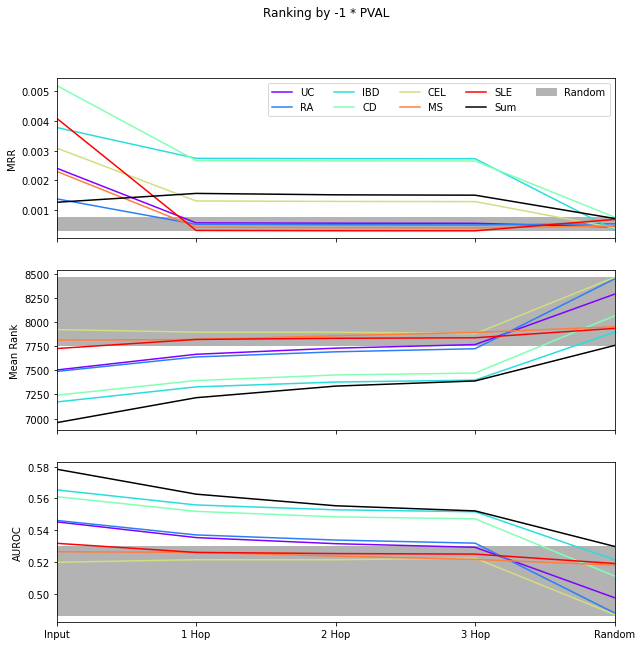

In [22]:
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [10, 10]

color = cm.rainbow(np.linspace(0, 1, len([0,3,6,9,12,15,18])))
color = np.concatenate((color,np.asarray((0,0,0,1)).reshape(1,-1)))

fig, axes = plt.subplots(3,1, sharex=True)

patches = []
randoms = np.empty((len([0,3,6,9,12,15,18]) + 1, 3))

for j, features in enumerate([2,5,8,11,14,17,20, [2,5,8,11,14,17,20]]):
    feature_values = -1 * np.sum(X[:,features].reshape(X.shape[0],-1), axis=1)
    #feature_values = X[:, 2]
    metrics.update(feature_values, "all")
    results_0 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = -1 * np.sum(X_transformed[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_1 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = -1 * np.sum(X_transformed_2[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_2 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    feature_values = -1 * np.sum(X_transformed_3[:,features].reshape(X.shape[0],-1), axis=1)
    metrics.update(feature_values, "all")
    results_3 = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    random = np.random.normal(size=X.shape[0])
    metrics.update(random, "all")
    results_random = metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

    metrics_list = ["MRR", "Mean Rank", "AUROC"]

    results = np.vstack((results_0, results_1, results_2, results_3, results_random))
    
    for i in range(results.shape[1]):
        patch, = axes[i].plot(results[:, i], color=color[j])
        axes[i].set_ylabel(metrics_list[i])
    randoms[j, :] = results_random
    patches.append(patch)


for i in range(results.shape[1]):
    axes[i].fill_between(x=(-1,5), y1=np.max(randoms[:, i]), y2=np.min(randoms[:, i]), color=[(0.7,0.7,0.7,1)], zorder=-1)

patches.append(Patch(facecolor=(0.7,0.7,0.7,1), edgecolor=(0.7,0.7,0.7,1),
                         label='Random'))

legend_values = [feature_names[i][2:] for i in [2,5,8,11,14,17,20]] + ["Sum", "Random"]
axes[0].legend(patches, legend_values, loc='upper right', ncol=5)
plt.xticks([0,1,2,3,4],["Input", "1 Hop", "2 Hop", "3 Hop", "Random"])
plt.xlim((0,4))
plt.suptitle("Ranking by -1 * PVAL")
plt.show

In [181]:
random = np.random.normal(size=X.shape[0])
metrics.update(random, "all")
metrics.get_metrics("mrr_filtered", "mean_rank_filtered", "auroc")

[0.00030324135100273945, 8455.041904761905, 0.4876027695762225]

In [208]:
color = cm.rainbow(np.linspace(0, 1, len([0,3,6,9,12,15,18])))
color

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.70588235e-01, 4.94655843e-01, 9.66718404e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 4.94655843e-01, 2.55842778e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00]])

In [214]:
np.concatenate((color,np.asarray((1,1,1,1)).reshape(1,-1)))

array([[5.00000000e-01, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [1.70588235e-01, 4.94655843e-01, 9.66718404e-01, 1.00000000e+00],
       [1.66666667e-01, 8.66025404e-01, 8.66025404e-01, 1.00000000e+00],
       [5.03921569e-01, 9.99981027e-01, 7.04925547e-01, 1.00000000e+00],
       [8.33333333e-01, 8.66025404e-01, 5.00000000e-01, 1.00000000e+00],
       [1.00000000e+00, 4.94655843e-01, 2.55842778e-01, 1.00000000e+00],
       [1.00000000e+00, 1.22464680e-16, 6.12323400e-17, 1.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])